In [1]:
import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder
from scipy.stats import spearmanr
import statistics
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import seed

## Data setup

In [2]:
test_df = pd.read_csv("recent_tests.csv", sep=';', dtype={'Sesssion': 'str'})

#Resetting types
test_df.astype({'Timestamp': 'str',
                'Client IP Block': 'str',
                'ASN': 'str', 
                'Country': 'str', 
                'NAT': 'str', 
                'Outbound Private Status': 'str',
               'Adjacent Spoof Prefix Length': 'str'}).dtypes

df_received = test_df.loc[test_df['Outbound Routable Status'] == 'received']

df_received.head()

/Users/almagunn/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Session,Timestamp,Client IP Block,ASN,Country,NAT,Outbound Private Status,Outbound Routable Status,Adjacent Spoof Prefix Length
6,966236,2020-08-31 23:48:14,103.132.11.x/24,138528 (EMPIRETECH-AS-AP),"khm (Cambodia, Kingdom of)",yes,received,received,/8
23,966208,2020-08-31 23:21:12,177.190.91.x/24,262977,bra (Brazil),yes,rewritten,received,none
44,966170,2020-08-31 22:18:40,2804:4e08:20xx::/40,268235,bra (Brazil),no,received,received,/16
53,966159,2020-08-31 22:00:03,2804:4e08:20xx::/40,268235,bra (Brazil),no,received,received,/16
55,966158,2020-08-31 21:59:07,2a02:27b0:45xx::/40,9146 (BIHNET),bih (Bosnia and Herzegovina),no,received,received,/16


In [3]:
remedies_df = pd.read_csv("remedies.csv", sep=';')
remedies_df.tail()

,ASN,Country,IP Block,First Spoofed Timestamp,First Fixed Timestamp
814,7377 (UCSD),usa (United States),2607:f720:fxx::/64,2016-02-12 19:35:38,2016-06-14 19:32:14
815,262426,bra (Brazil),177.39.131.x/32,2016-05-25 22:11:10,2016-05-26 13:02:54
816,36352 (AS-COLOCROSSING),usa (United States),107.172.23.x/24,2015-10-23 14:44:30,2016-04-23 18:25:01
817,16276 (OVH),deu (Germany),51.254.23.x/24,2016-02-28 20:58:58,2016-04-17 18:58:38
818,8816 (IT-STCOM),ita (Italy),212.45.144.x/32,2016-03-31 15:03:36,2016-04-08 05:03:56


In [4]:
#Get remediation blocks
remedies_count_df = remedies_df.groupby('Country')
remedies_count_df = remedies_count_df.count()[['IP Block']]
remedies_count_df = remedies_count_df.rename(columns={"IP Block" : "Blocks Fixed"})

In [5]:
#Get other spoofable blocks
spoofable_df = df_received.groupby('Country')
spoofable_df = spoofable_df.count()[['Client IP Block']]
spoofable_df = spoofable_df.rename(columns={"Client IP Block" : "Spoofable Blocks"})

spoofable_country_list = df_received['Country'].unique()

## Helper functions

In [23]:
#Function to calculate remediation rate
#Input: list of countries
#Outputs remediation rate per country
def calc_remediation_rates(countries):
    remediation_rates = []
    
    for country in countries:
        remedies_row = remedies_count_df.loc[country]
        spoofable_row = spoofable_df.loc[country]

        remediation_rate = (remedies_row['Blocks Fixed'] / (remedies_row['Blocks Fixed'] + spoofable_row['Spoofable Blocks'])*100.0)
        remediation_rates.append(round(remediation_rate,2))
        
    return remediation_rates

#Average calculation
def calc_average(lst):
    return round(sum(lst)/len(lst),2)

#Get in the country-value tuple and splits the list into two lists, higher and lower than the median
def compute_split(combo):
    median = statistics.median(x[1] for x in combo)
    print(median)
    
    higher = []
    lower = []
    
    for value in combo:
        if value[1] > median:
            higher.append(value)
        else:
            lower.append(value)
            
    return higher, lower

#Get in the country-value tuple and splits the list into two lists, higher and lower than the median
def compute_average_split(combo):
    median = statistics.mean(x[1] for x in combo)
    print(median)
    
    higher = []
    lower = []
    
    for value in combo:
        if value[1] > median:
            higher.append(value)
        else:
            lower.append(value)
            
    return higher, lower

#Extraction of the remedation rate column
def extract_remediation(values, df, column, col_of_interest):
    rates = []
    for value in values:
        df_current_row = df.loc[df[column] == value[0]]
        rate = df_current_row[col_of_interest].item()
        rates.append(rate)
        
    return rates

#Write out the new grouping into the dataframe
def set_group(dataframe, values, col_to_change, tag):
    for value in values:
        dataframe.loc[dataframe["Countries"] == value[0], col_to_change] = tag
        
    return dataframe

In [8]:
#General continental analysis
unique_countries_remedies = list(remedies_count_df.index)
unique_countries = [x for x in spoofable_country_list if x in unique_countries_remedies]

europe = ['aut (Austria)',
          'bgr (Bulgaria)',
          'bih (Bosnia and Herzegovina)',
          'che (Switzerland)',
          'cze (Czech Republic)',
          'deu (Germany)',
          'esp (Spain)',
          'fra (France)',
          'gbr (United Kingdom)',
          'grc (Greece)',
          'hun (Hungary)',
          'irl (Ireland)',
          'ita (Italy)',
          'ltu (Lithuania)',
          'nld (Netherlands)',
          'nor (Norway)',
          'pol (Poland)',
          'prt (Portugal)',
          'reu (Reunion [French])',
          'rou (Romania)',
          'svn (Slovenia)',
          'swe (Sweden)',
          'ukr (Ukraine)' 
         ]

north_america = ['can (Canada)', 
                 'usa (United States)']

south_america = ['arg (Argentina)',
                 'bol (Bolivia)',
                 'bra (Brazil)',
                 'chl (Chile)',
                 'cri (Costa Rica)',
                 'hti (Haiti)',
                 'mex (Mexico)',
                 'pan (Panama)',
                 'pry (Paraguay)',
                 'ury (Uruguay)']

asia = ['bgd (Bangladesh)',
        'idn (Indonesia)',
        'ind (India)',
        'irn (Iran)',
        'irq (Iraq)',
        'isr (Israel)',
        'jpn (Japan)',
        'kaz (Kazakhstan)',
        'kor (South Korea)',
        'mmr (Myanmar)',
        'npl (Nepal)',
        'pak (Pakistan)',
        'phl (Philippines)',
        'rus (Russian Federation)',
        'tha (Thailand)',
        'tur (Turkey)',
        'twn (Taiwan)']

africa = ['ken (Kenya)', 
          'khm (Cambodia, Kingdom of)',
          'mar (Morocco)',
          'mus (Mauritius)',
          'tza (Tanzania)',
          'zaf (South Africa)']

australia = ['aus (Australia)', 'nzl (New Zealand)']

remediation_averages = []
europe_remediation_rates = calc_remediation_rates(europe)
remediation_averages.append(calc_average(europe_remediation_rates))

na_remediation_rates = calc_remediation_rates(north_america)
remediation_averages.append(calc_average(na_remediation_rates))

sa_remediation_rates = calc_remediation_rates(south_america)
remediation_averages.append(calc_average(sa_remediation_rates))

asia_remediation_rates = calc_remediation_rates(asia)
remediation_averages.append(calc_average(asia_remediation_rates))

africa_remediation_rates = calc_remediation_rates(africa)
remediation_averages.append(calc_average(africa_remediation_rates))

australia_remediation_rates = calc_remediation_rates(australia)
remediation_averages.append(calc_average(australia_remediation_rates))
                            
continents = ['Europe', 'North America', 'South America', 'Asia', 'Africa', 'Australia']

data = {'Continent': continents,
       'Remediation rates': remediation_averages}

continent_df = pd.DataFrame(data, columns=['Continent', 'Remediation rates'])

enc = LabelEncoder()
enc.fit(continent_df['Continent'])
continent_df['continent_encoded'] = enc.transform(continent_df['Continent'])

corr_continent_df = pd.DataFrame.corr(continent_df, method='spearman')
corr_continent_df.head()

,Remediation rates,continent_encoded
Remediation rates,1.000000,-0.257143
continent_encoded,-0.257143,1.000000


In [9]:
#Linear regression of continental analysis
X = continent_df['continent_encoded']
Y = continent_df['Remediation rates']

model = sm.OLS(Y, X).fit()
predictions = model.predict(X) 

print_model = model.summary()
print(print_model)

                                 OLS Regression Results                                
Dep. Variable:      Remediation rates   R-squared (uncentered):                   0.537
Model:                            OLS   Adj. R-squared (uncentered):              0.444
Method:                 Least Squares   F-statistic:                              5.790
Date:                Wed, 04 Nov 2020   Prob (F-statistic):                      0.0611
Time:                        11:32:34   Log-Likelihood:                         -26.433
No. Observations:                   6   AIC:                                      54.87
Df Residuals:                       5   BIC:                                      54.66
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

/Users/almagunn/anaconda3/lib/python3.7/site-packages/statsmodels/stats/stattools.py:71: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  "samples were given." % int(n), ValueWarning)


## GDP related analysis

In [12]:
#Obtain GDP data
GDP_df = pd.read_csv("2019_GDP.csv")
GDP_df = GDP_df.rename(columns = {"2019 [YR2019]":"GDP 2019"})
GDP_df = GDP_df.dropna()

GDP_df.head()

,Series Name,Series Code,Country Name,Country Code,GDP 2019
0,GDP (current US$),NY.GDP.MKTP.CD,Afghanistan,AFG,19101353832.7371
1,GDP (current US$),NY.GDP.MKTP.CD,Albania,ALB,15278077446.8643
2,GDP (current US$),NY.GDP.MKTP.CD,Algeria,DZA,169988236398.126
3,GDP (current US$),NY.GDP.MKTP.CD,American Samoa,ASM,..
4,GDP (current US$),NY.GDP.MKTP.CD,Andorra,AND,3154057987.23833


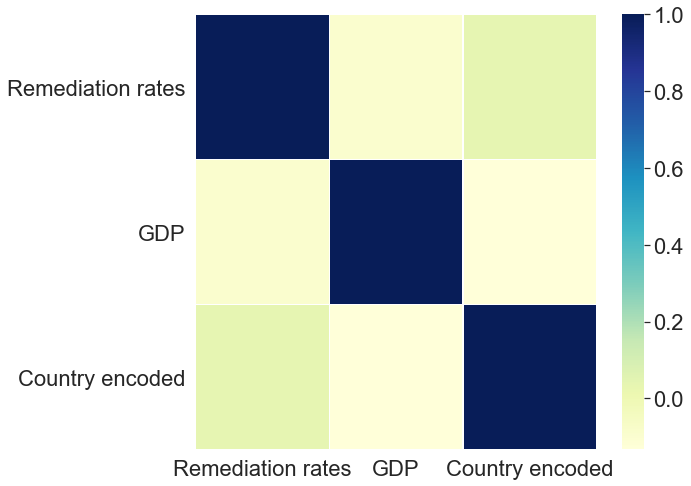

In [13]:
#Generating countries which appear in unique countries and spoofable data
GDP_countries = GDP_df["Country Name"].unique()

unique_countries = list(remedies_count_df.index)

unique_countries = [x for x in spoofable_country_list if x in unique_countries_remedies]

unique_countries_short = []

GDP_scores = []

country_GDP_combo = []

for unique_country in unique_countries:
    for country in GDP_countries:
        if country in unique_country:
            unique_countries_short.append(unique_country)
            GDP_curr_row = GDP_df.loc[GDP_df['Country Name'] == country]
            GDP_curr_score = GDP_curr_row["GDP 2019"].item()
            GDP_scores.append(float(GDP_curr_score))
            
            country_GDP_combo.append((unique_country, float(GDP_curr_score)))
            break

unique_country_remediation = calc_remediation_rates(unique_countries_short)

data = {'Countries': unique_countries_short,
       'Remediation rates': unique_country_remediation,
       'GDP': GDP_scores}

GDP_short_df = pd.DataFrame(data, columns=['Countries', 'Remediation rates', 'GDP'])

enc = LabelEncoder()
enc.fit(GDP_short_df['Countries'])
GDP_short_df['Country encoded'] = enc.transform(GDP_short_df['Countries'])

GDP_corr_df = pd.DataFrame.corr(GDP_short_df, method='spearman')

GDP_corr_df.head()

f, ax = plt.subplots(figsize =(9, 8)) 
sns.set(font_scale=2)
sns.heatmap(GDP_corr_df, ax = ax, cmap ="YlGnBu",linewidths = 0.1)

In [14]:
#Compute the four grouping values
higher_GDP_half, lower_GDP_half = compute_split(country_GDP_combo)
low_GDP_quarter, lowest_GDP_quarter = compute_split(lower_GDP_half)
highest_GDP_quarter, high_GDP_quarter = compute_split(higher_GDP_half)

292444706937.8925
72006516176.9143
1014130587956.7915


In [15]:
#Get remediation rates based on grouping
lowest_GDP_quarter_remediation = extract_remediation(lowest_GDP_quarter, GDP_short_df, "Countries", "Remediation rates")
low_GDP_quarter_remediation = extract_remediation(low_GDP_quarter, GDP_short_df, "Countries", "Remediation rates")
high_GDP_quarter_remediation = extract_remediation(high_GDP_quarter, GDP_short_df, "Countries", "Remediation rates")
highest_GDP_quarter_remediation = extract_remediation(highest_GDP_quarter, GDP_short_df, "Countries", "Remediation rates")

In [16]:
#One way ANOVA testing
stats.f_oneway(lowest_GDP_quarter_remediation, low_GDP_quarter_remediation, high_GDP_quarter_remediation, highest_GDP_quarter_remediation)

F_onewayResult(statistic=0.8056518565165799, pvalue=0.4964484171683027)

In [17]:
#Add grouping to the dataframe
GDP_short_df['GDP group'] = ''

GDP_short_df = set_group(GDP_short_df, lowest_GDP_quarter, "GDP group", "Very low")
GDP_short_df = set_group(GDP_short_df, low_GDP_quarter, "GDP group", "Low")
GDP_short_df = set_group(GDP_short_df, high_GDP_quarter, "GDP group", "High")
GDP_short_df = set_group(GDP_short_df, highest_GDP_quarter, "GDP group", "Very high")

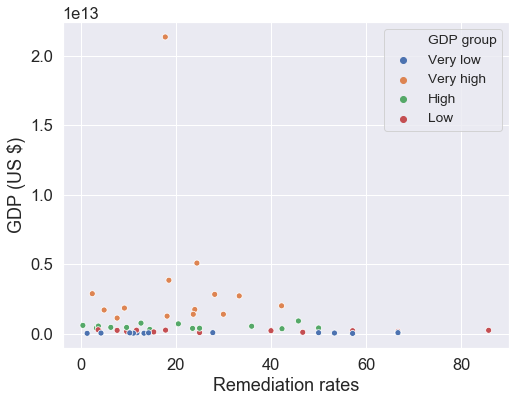

In [130]:
#Visualize distribution in a scatterplot
fig, ax = plt.subplots(figsize=(8,6))
sns.set(font_scale=1.25)
sns.scatterplot(x='Remediation rates', y='GDP', hue='GDP group', data=GDP_short_df) 

plt.ylabel("GDP (US $)")
plt.show()

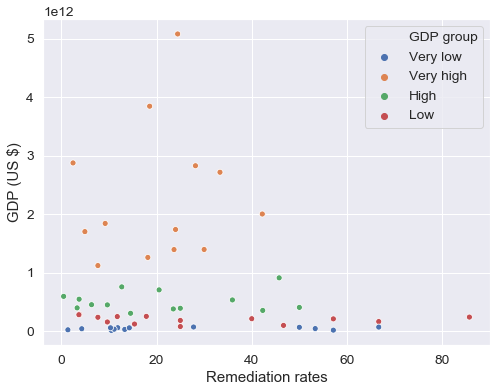

In [132]:
#Visualize the distribution without the states
GDP_exUS_df = GDP_short_df.loc[~(GDP_short_df['Countries'] == 'usa (United States)')]

fig, ax = plt.subplots(figsize=(8,6))
sns.set(font_scale=1.25)
sns.scatterplot(x='Remediation rates', y='GDP', hue='GDP group', data=GDP_exUS_df) 

plt.ylabel("GDP (US $)")
plt.show()

## IDI score related analysis

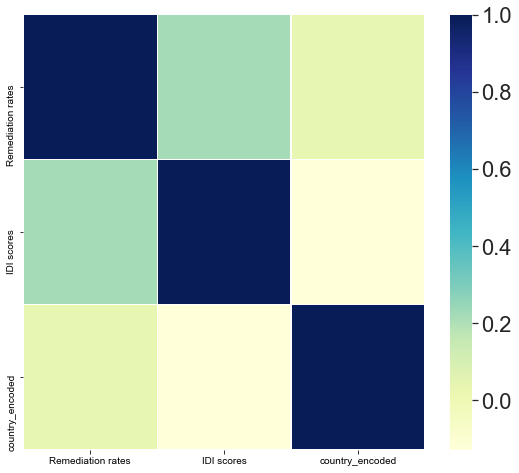

In [10]:
#Set up did database and visualize correlation
IDI_scores_df = pd.read_csv('IDI_2017_Rank.csv',sep=';')
IDI_countries = IDI_scores_df['Economy'].unique()

unique_countries_remedies = list(remedies_count_df.index)

unique_countries = [x for x in spoofable_country_list if x in unique_countries_remedies]
IDI_countries_short = []
unique_countries_short = []

IDI_scores = []
IDI_scores_combo = []

for unique_country in unique_countries:
    for country in IDI_countries:
        if country in unique_country:
            #IDI_countries_short.append(country)
            unique_countries_short.append(unique_country)
            IDI_curr_row = IDI_scores_df.loc[IDI_scores_df['Economy'] == country]
            IDI_curr_score = IDI_curr_row["IDI 2017 Value"].item()
            IDI_scores.append(IDI_curr_score)
            IDI_scores_combo.append((unique_country, IDI_curr_score))
            break

unique_country_remediation = calc_remediation_rates(unique_countries_short)

data = {'Countries': unique_countries_short,
       'Remediation rates': unique_country_remediation,
       'IDI scores': IDI_scores}

IDI_scores_df = pd.DataFrame(data, columns=['Countries', 'Remediation rates', 'IDI scores'])

enc = LabelEncoder()
enc.fit(IDI_scores_df['Countries'])
IDI_scores_df['country_encoded'] = enc.transform(IDI_scores_df['Countries'])

corr_IDI_df = pd.DataFrame.corr(IDI_scores_df, method='spearman')

f, ax = plt.subplots(figsize =(9, 8)) 
sns.set(font_scale=2)
sns.heatmap(corr_IDI_df, ax = ax, cmap ="YlGnBu", linewidths = 0.1)


Text(0.5, 1.0, 'IDI score')

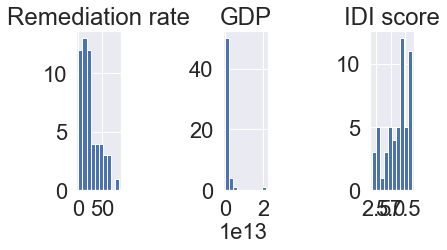

In [19]:
#Make histograms to evaluate distribution
seed(1)

fig, axs = plt.subplots(1, 3, tight_layout=True)

axs[0].hist(GDP_short_df['Remediation rates'])
axs[0].set_title('Remediation rate')
axs[1].hist(GDP_short_df['GDP'])
axs[1].set_title('GDP')
axs[2].hist(IDI_scores_df['IDI scores'])
axs[2].set_title('IDI score')

In [24]:
#Compute the groupings
higher_IDI_half, lower_IDI_half = compute_average_split(IDI_scores_combo)
low_IDI_quarter, lowest_IDI_quarter = compute_average_split(lower_IDI_half)
highest_IDI_quarter, high_IDI_quarter = compute_average_split(higher_IDI_half)

6.13
4.157826086956522
7.593225806451613


In [25]:
#Get distribution based on groupings
lowest_IDI_quarter_remediation = extract_remediation(lowest_IDI_quarter, IDI_scores_df, "Countries", "Remediation rates")
low_IDI_quarter_remediation = extract_remediation(low_IDI_quarter, IDI_scores_df, "Countries", "Remediation rates")
high_IDI_quarter_remediation = extract_remediation(high_IDI_quarter, IDI_scores_df, "Countries", "Remediation rates")
highest_IDI_quarter_remediation = extract_remediation(highest_IDI_quarter, IDI_scores_df, "Countries", "Remediation rates")

In [26]:
#One way ANOVA tests
stats.f_oneway(lowest_IDI_quarter_remediation, low_IDI_quarter_remediation, high_IDI_quarter_remediation, highest_IDI_quarter_remediation)

F_onewayResult(statistic=0.4030108154678864, pvalue=0.751452859917694)

In [27]:
#Add column for grouping to database
IDI_scores_df['IDI group'] = ''

IDI_scores_df = set_group(IDI_scores_df, lowest_IDI_quarter, "IDI group", "Very low")
IDI_scores_df = set_group(IDI_scores_df, low_IDI_quarter, "IDI group", "Low")
IDI_scores_df = set_group(IDI_scores_df, high_IDI_quarter, "IDI group", "High")
IDI_scores_df = set_group(IDI_scores_df, highest_IDI_quarter, "IDI group", "Very high")

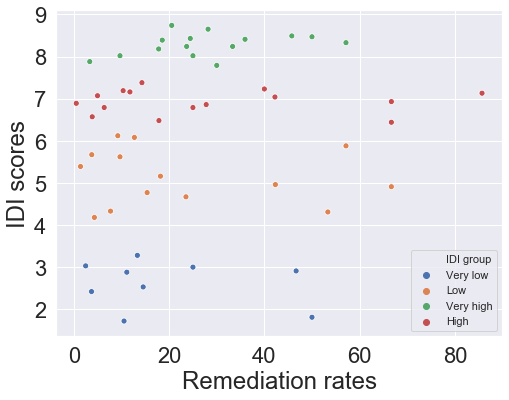

In [28]:
#Create scatterplot of distribution
fig, ax = plt.subplots(figsize=(8,6))
sns.set(font_scale = 1)
sns.scatterplot(x='Remediation rates', y='IDI scores', hue='IDI group', data=IDI_scores_df) 

plt.ylabel("IDI scores")
plt.legend(loc='lower right')
plt.show()